In [34]:
import shap
%load_ext autoreload
%autoreload 2

from data_prep import prepare_datasets, get_dfs
import random
import os.path as op
from collections import Counter
import xgboost
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd


seed = 42
random.seed(seed)
np.random.seed(seed)


LABELS = {0: "clear",
          1: "light cloud",
          2: "overcast",
          3: "light rain",
          4: "heavy rain",
          5: "storm"}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
if op.exists(op.join("data", "train.csv")) and op.exists(op.join("data", "val.csv")) and op.exists(op.join("data", "test.csv")):
    train_df = pd.read_csv(op.join("data", "train.csv"))
    val_df = pd.read_csv(op.join("data", "val.csv"))
    test_df = pd.read_csv(op.join("data", "test.csv"))
else:
    train_df, val_df, test_df = prepare_datasets(
        op.join("data", "weather.csv"))
df_dct = {"train": train_df, "val": val_df, "test": test_df}
df_timed_dct = get_dfs(df_dct)


Creating dataset for time_offset=5
Creating dataset for time_offset=10
Creating dataset for time_offset=15
Creating dataset for time_offset=30
Creating dataset for time_offset=60


# Classification Viz

In [36]:
# train a model with single tree
models = {}
for time_offset in ["5","10","15","30","60"]:

    train_df = df_timed_dct[time_offset]["train"]
    trainX = train_df[train_df.columns[:-2]]
    trainY = train_df[train_df.columns[-2]]

    test_df = df_timed_dct[time_offset]["test"]
    testX = test_df[test_df.columns[:-2]]
    testY = test_df[test_df.columns[-2]]

    d_train = xgboost.DMatrix(trainX, label=trainY)
    d_test = xgboost.DMatrix(testX, label=testY)

    params = {
        "eta": 0.01,
        "objective": "multi:softmax",
        "subsample": 0.5,
        "base_score": np.mean(trainY),
        "eval_metric": "mlogloss",
        "num_class":7,
    }
    model = xgboost.train(params, d_train, 5000, evals=[
                        (d_test, "test")], verbose_eval=100, early_stopping_rounds=20)
    models[time_offset] = model

[0]	test-mlogloss:1.91758
[100]	test-mlogloss:0.76087
[200]	test-mlogloss:0.48180
[300]	test-mlogloss:0.40039
[400]	test-mlogloss:0.37592
[500]	test-mlogloss:0.36262
[0]	test-mlogloss:1.92119
[100]	test-mlogloss:0.95063
[200]	test-mlogloss:0.77014
[300]	test-mlogloss:0.74363
[321]	test-mlogloss:0.74914
[0]	test-mlogloss:1.92792
[100]	test-mlogloss:1.32922
[200]	test-mlogloss:1.19766
[300]	test-mlogloss:1.16948
[303]	test-mlogloss:1.17119
[0]	test-mlogloss:1.92524
[100]	test-mlogloss:1.33345
[200]	test-mlogloss:1.11638
[300]	test-mlogloss:1.03323
[320]	test-mlogloss:1.03989
[0]	test-mlogloss:1.92891
[100]	test-mlogloss:1.27981
[200]	test-mlogloss:1.04412
[300]	test-mlogloss:0.94102
[400]	test-mlogloss:0.84784
[500]	test-mlogloss:0.76565
[600]	test-mlogloss:0.73623
[614]	test-mlogloss:0.73645


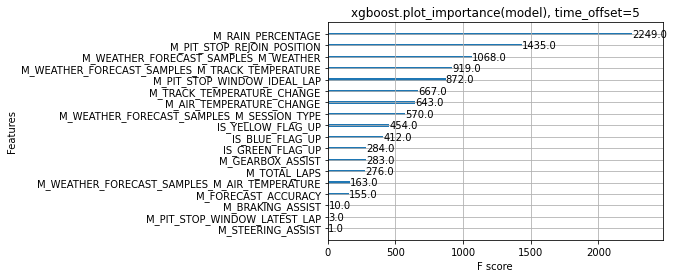

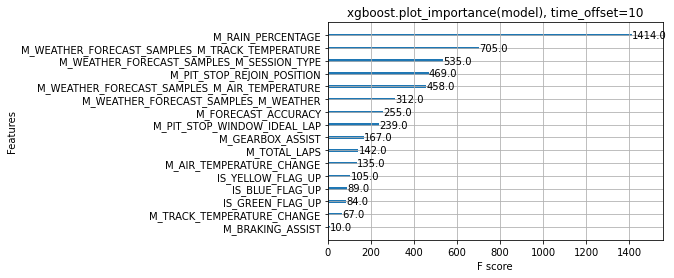

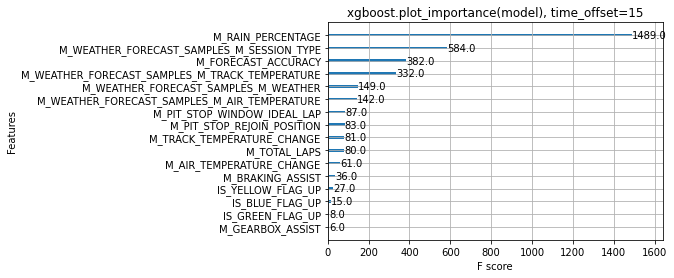

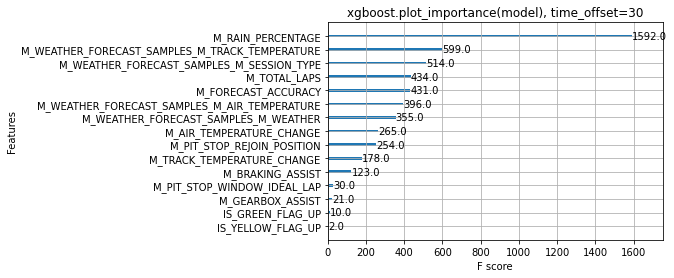

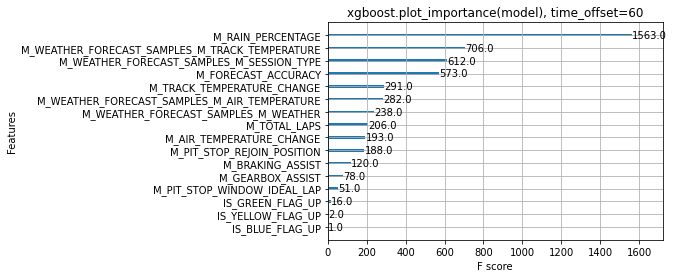

In [37]:
for time_offset, model in models.items():
    xgboost.plot_importance(model)
    plt.title(f"xgboost.plot_importance(model), time_offset={time_offset}")
    plt.show()


Time Offset = 5


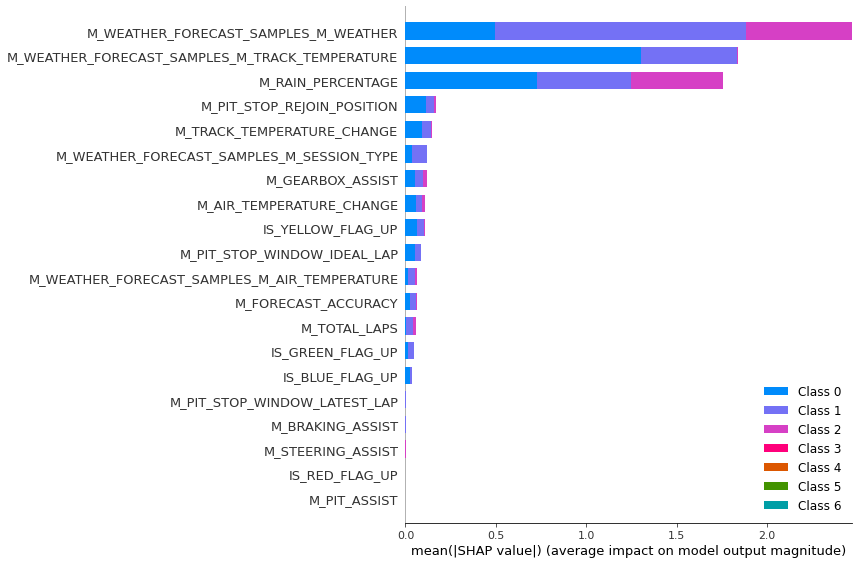

Time Offset = 10


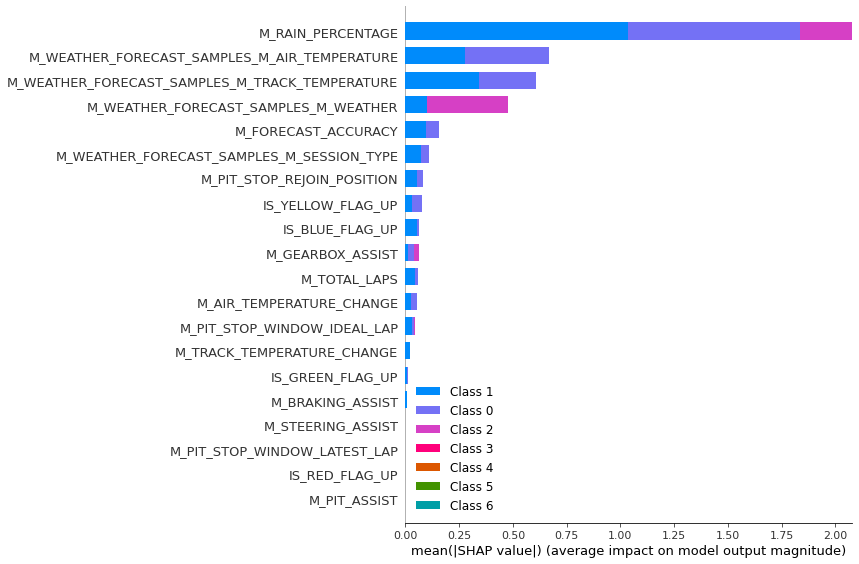

Time Offset = 15


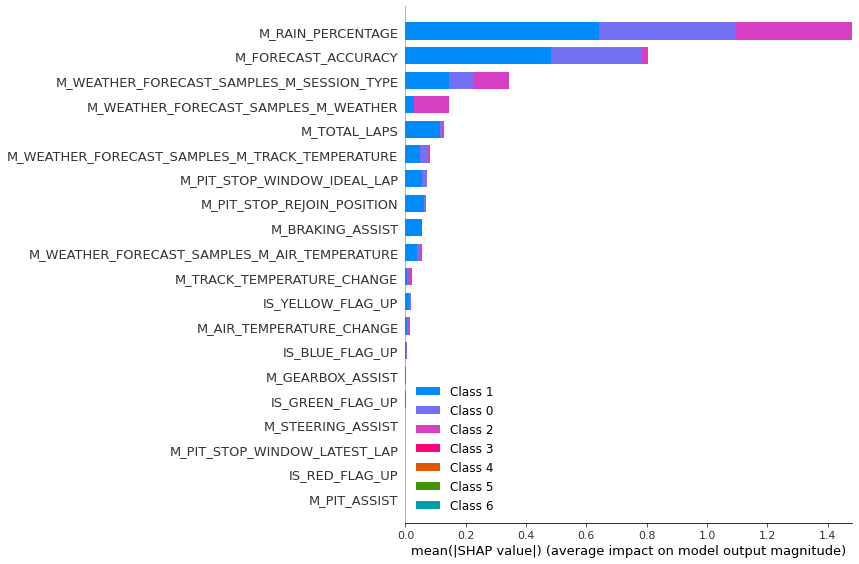

Time Offset = 30


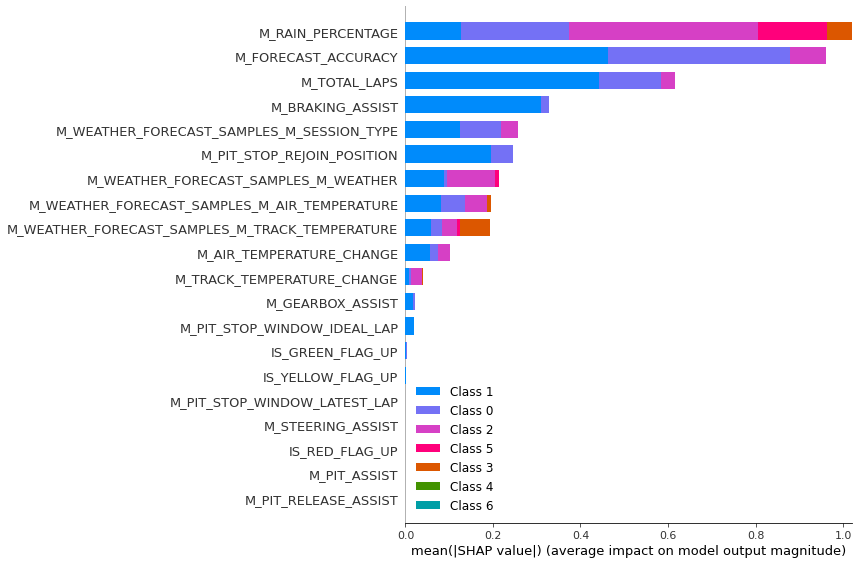

Time Offset = 60


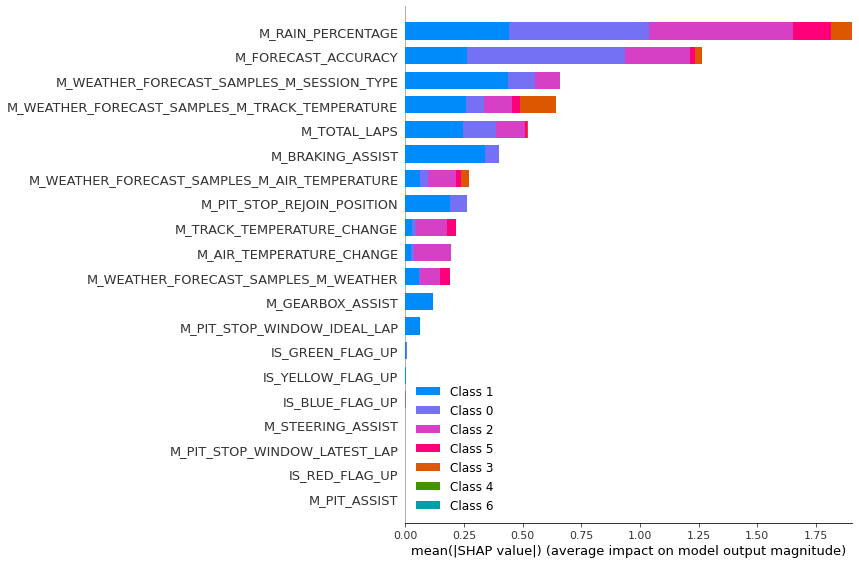

In [40]:
for time_offset, model in models.items():
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(trainX)
    print(f"Time Offset = {time_offset}")
    shap.summary_plot(shap_values,trainX, plot_type="bar")


# Regression Viz

In [44]:
# train a model with single tree
models = {}
for time_offset in ["5", "10", "15", "30", "60"]:
    train_df = df_timed_dct[time_offset]["train"]
    trainX = train_df[train_df.columns[:-2]]
    trainY = train_df[train_df.columns[-1]]

    test_df = df_timed_dct[time_offset]["test"]
    testX = test_df[test_df.columns[:-2]]
    testY = test_df[test_df.columns[-1]]

    d_train = xgboost.DMatrix(trainX, label=trainY)
    d_test = xgboost.DMatrix(testX, label=testY)

    params = {
        "eta": 0.01,
        "max_depth": 5,
        "subsample": 0.5,
        "base_score": 0,
    }
    model = xgboost.train(params, d_train, 5000, evals=[
        (d_test, "test")], verbose_eval=100, early_stopping_rounds=20)
    models[time_offset] = model


[0]	test-rmse:6.43882
[100]	test-rmse:3.35908
[200]	test-rmse:2.35163
[300]	test-rmse:1.97429
[400]	test-rmse:1.85657
[500]	test-rmse:1.81348
[600]	test-rmse:1.78984
[646]	test-rmse:1.78906
[0]	test-rmse:7.06322
[100]	test-rmse:4.64967
[200]	test-rmse:3.85155
[300]	test-rmse:3.56548
[400]	test-rmse:3.45041
[500]	test-rmse:3.41762
[566]	test-rmse:3.39957
[0]	test-rmse:9.43518
[100]	test-rmse:6.95157
[200]	test-rmse:6.08880
[300]	test-rmse:5.74671
[400]	test-rmse:5.58359
[450]	test-rmse:5.57177
[0]	test-rmse:11.54228
[100]	test-rmse:6.41999
[134]	test-rmse:6.49369
[0]	test-rmse:12.20707
[100]	test-rmse:8.77020
[200]	test-rmse:7.51391
[300]	test-rmse:7.17562
[400]	test-rmse:7.02255
[500]	test-rmse:6.95970
[600]	test-rmse:6.94050
[625]	test-rmse:6.94351


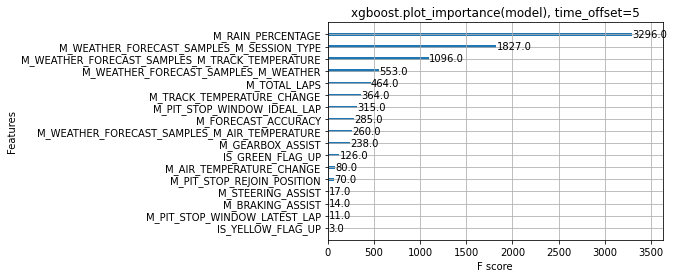

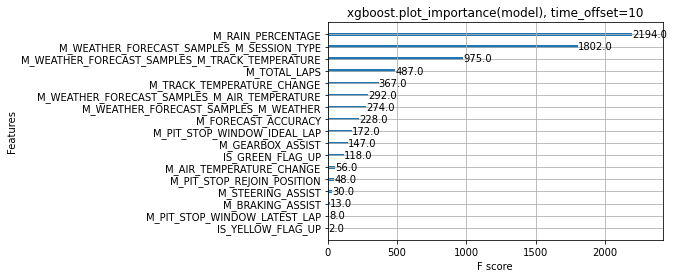

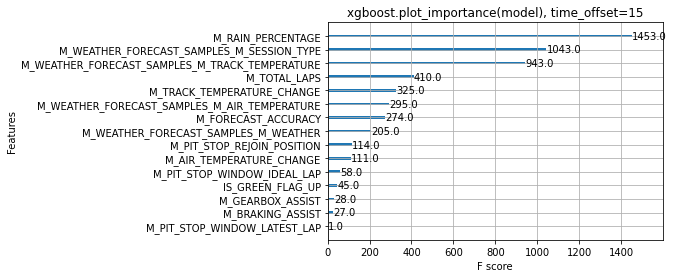

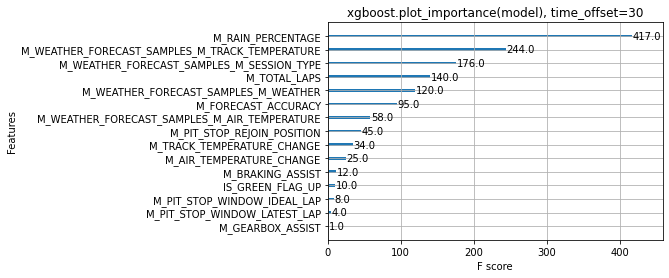

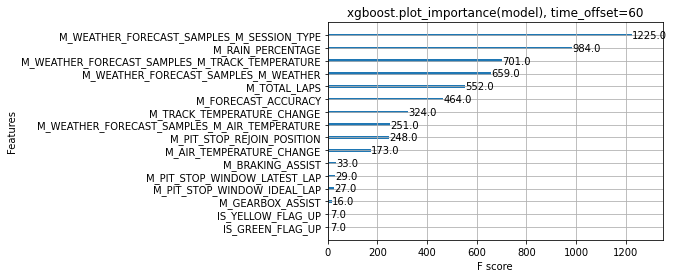

In [45]:
for time_offset, model in models.items():
    xgboost.plot_importance(model)
    plt.title(f"xgboost.plot_importance(model), time_offset={time_offset}")
    plt.show()


Time Offset = 5


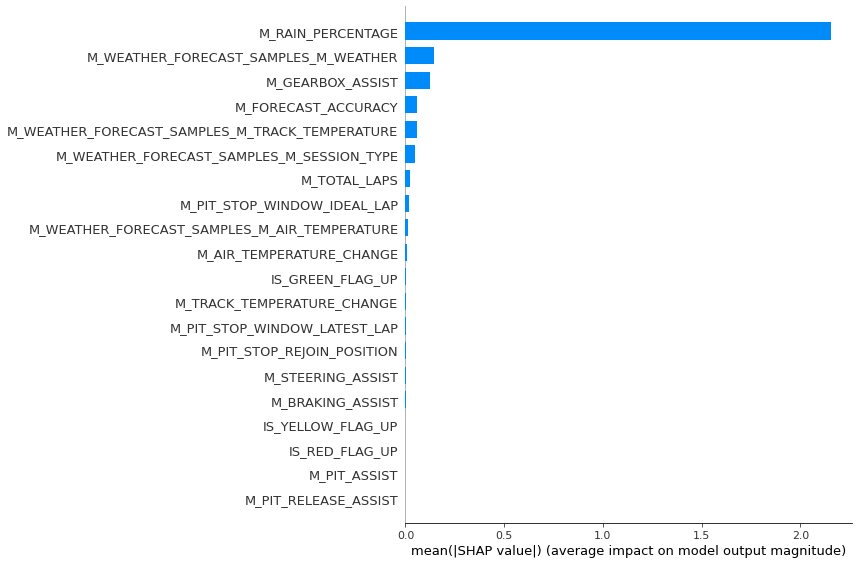

Time Offset = 10


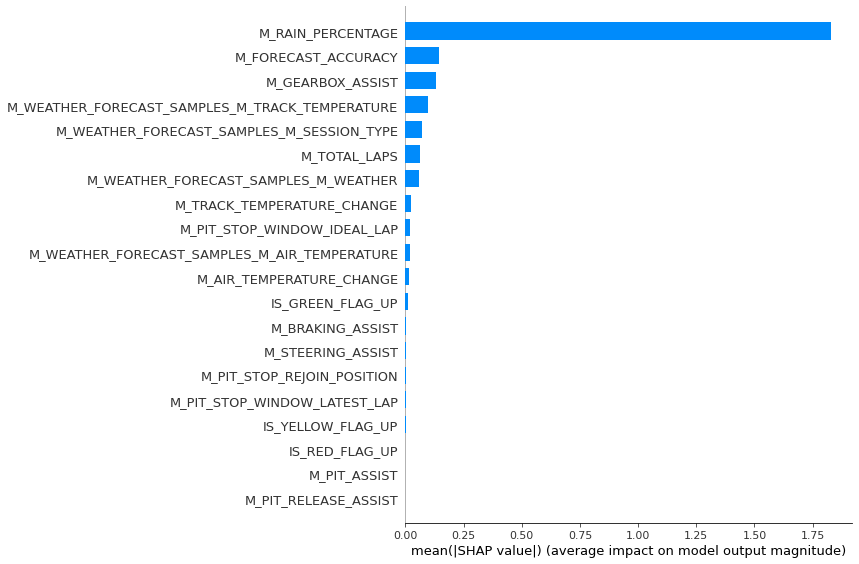

Time Offset = 15


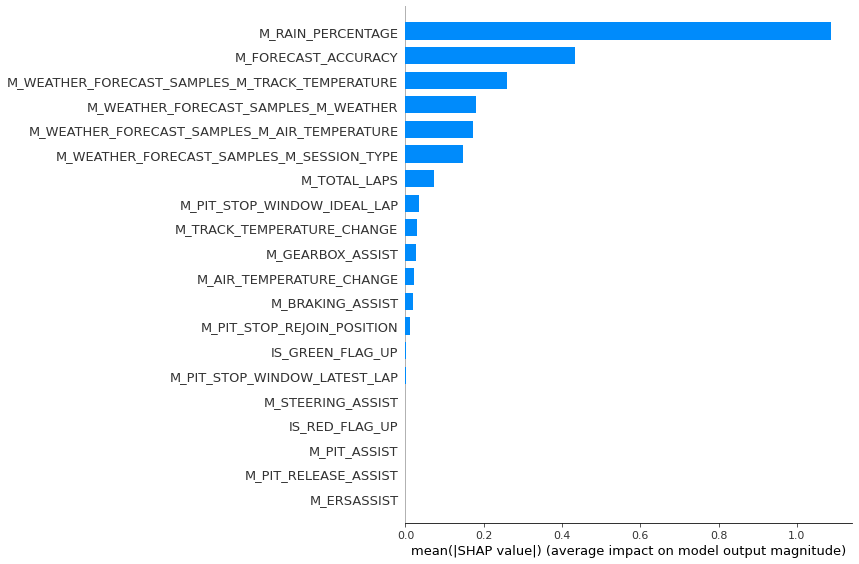

Time Offset = 30


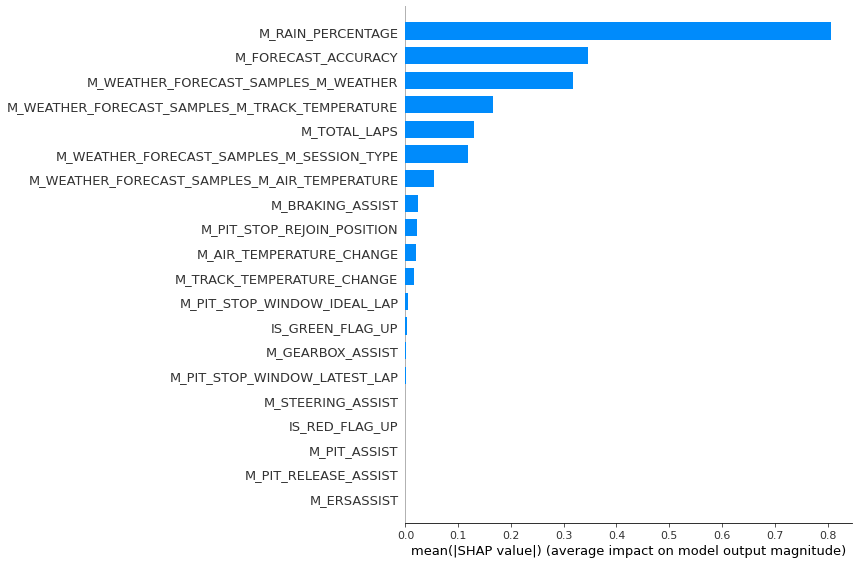

Time Offset = 60


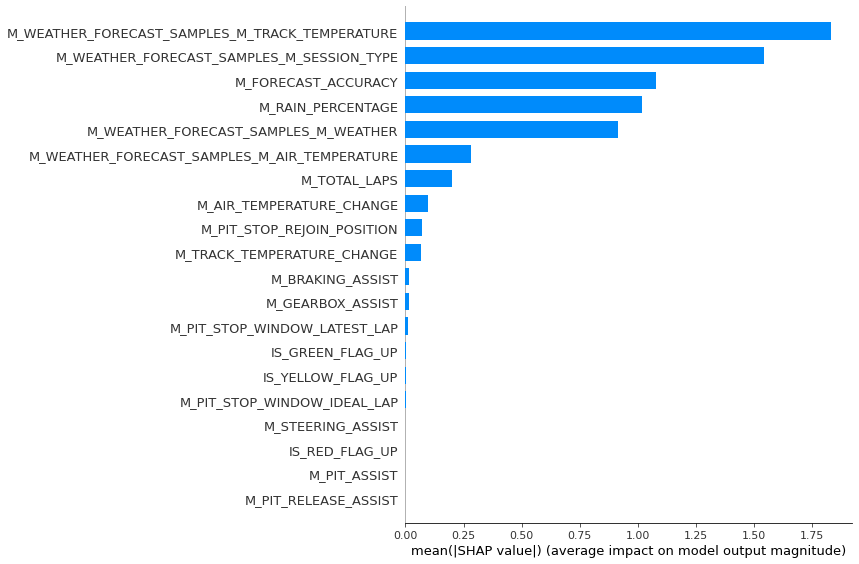

In [47]:
for time_offset, model in models.items():
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(trainX)
    print(f"Time Offset = {time_offset}")
    shap.summary_plot(shap_values, trainX, plot_type="bar")
